In [15]:
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [16]:
# Versatile device selection (CUDA -> MPS -> CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA:", torch.cuda.get_device_name(0))
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS backend")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple MPS backend


In [18]:
import sys, os
# Add repository root to sys.path so `src` package can be imported from this notebook
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
print('repo_root added to sys.path:', repo_root)

repo_root added to sys.path: /Users/pierre/Desktop/GitHub/MTL_Classification_Reconstruction


In [19]:
# Dataset helpers imported from module so DataLoader workers can pickle the classes
from src.dataset_utils import make_transform, RelabeledDataset, build_binary_dataset, relabel_imagefolder, indices_by_class

In [7]:
def evaluate(model, loader, logits_fn, device):
    model.eval()
    tot = 0
    ok = 0
    cm = torch.zeros(2,2, dtype=torch.int64)
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = logits_fn(model, x)
            pred = logits.argmax(1)
            ok += (pred == y).sum().item()
            tot += y.size(0)
            for t,p in zip(y.cpu(), pred.cpu()):
                cm[t, p] += 1
    acc = ok / tot if tot else float("nan")
    return acc, cm

def train_classifier(model, train_loader, val_loader, device, lr=1e-3, epochs=10, patience=10):
    ce = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    best = float("inf")
    bad = 0
    hist = []
    for epoch in range(epochs):
        model.train()
        run = 0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss = ce(logits, y)
            loss.backward()
            opt.step()
            run += loss.item()
        run /= len(train_loader)
        model.eval()
        val = 0.0
        ok, tot = 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                logits = model(x)
                loss = ce(logits, y)
                val += loss.item()
                ok += (logits.argmax(1)==y).sum().item()
                tot += y.size(0)
        val /= len(val_loader)
        acc = ok/tot
        hist.append((run, val, acc))
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {run:.4f} | Val Loss: {val:.4f} | Val Acc: {acc:.4f}")
        if val < best:
            best = val
            bad = 0
            best_w = model.state_dict()
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping triggered.")
                break
    model.load_state_dict(best_w)
    return model, hist

def train_mtl(model, train_loader, val_loader, device, alpha=0.6, lr=1e-3, epochs=10, patience=10):
    ce = nn.CrossEntropyLoss()
    rec = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    best = float("inf")
    bad = 0
    hist = []
    for epoch in range(epochs):
        model.train()
        tr = 0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            logits, recon = model(x)
            lc = ce(logits, y)
            lr_ = rec(recon, x)
            loss = alpha*lc + (1-alpha)*lr_
            loss.backward()
            opt.step()
            tr += loss.item()
        tr /= len(train_loader)
        model.eval()
        vl, ok, tot = 0.0, 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                logits, recon = model(x)
                lc = ce(logits, y)
                lr_ = rec(recon, x)
                loss = alpha*lc + (1-alpha)*lr_
                vl += loss.item()
                ok += (logits.argmax(1)==y).sum().item()
                tot += y.size(0)
        vl /= len(val_loader)
        acc = ok/tot
        hist.append((tr, vl, acc))
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {tr:.4f} | Val Loss: {vl:.4f} | Val Acc: {acc:.4f}")
        if vl < best:
            best = vl
            bad = 0
            best_w = model.state_dict()
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping triggered.")
                break
    model.load_state_dict(best_w)
    return model, hist

def train_soft_share(model, train_loader, val_loader, device, alpha=0.9, beta=0.09, gamma=0.01, mask_ratio=0.65, lr=1e-3, epochs=10, patience=10):
    ce = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    best = float("inf")
    bad = 0
    for epoch in range(epochs):
        model.train()
        tr = 0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            m = (torch.rand_like(x[:, :1]) < mask_ratio).float()
            xm = x*(1-m)
            opt.zero_grad()
            logits, recon, zc, zr = model(xm)
            lc = ce(logits, y)
            l1 = torch.abs(recon - x)*m
            lr_ = l1.sum()/(m.sum()*x.size(1) + 1e-6)
            la = F.mse_loss(zc, zr)
            loss = alpha*lc + beta*lr_ + gamma*la
            loss.backward()
            opt.step()
            tr += loss.item()
        tr /= len(train_loader)
        model.eval()
        vl, ok, tot = 0.0, 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                m = (torch.rand_like(x[:, :1]) < mask_ratio).float()
                xm = x*(1-m)
                logits, recon, zc, zr = model(xm)
                lc = ce(logits, y)
                l1 = torch.abs(recon - x)*m
                lr_ = l1.sum()/(m.sum()*x.size(1) + 1e-6)
                la = F.mse_loss(zc, zr)
                loss = alpha*lc + beta*lr_ + gamma*la
                vl += loss.item()
                ok += (logits.argmax(1)==y).sum().item()
                tot += y.size(0)
        vl /= len(val_loader)
        acc = ok/tot
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {tr:.4f} | Val Loss: {vl:.4f} | Val Acc: {acc:.4f}")
        if vl < best:
            best = vl
            bad = 0
            best_w = model.state_dict()
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping triggered.")
                break
    model.load_state_dict(best_w)
    return model

def show_reconstructions(model, loader, recon_fn, device, n=6):
    model.eval()
    imgs, _ = next(iter(loader))
    imgs = imgs[:n].to(device)
    with torch.no_grad():
        recon = recon_fn(model, imgs)
    imgs = imgs.cpu().permute(0,2,3,1)
    recon = recon.cpu().permute(0,2,3,1)
    imgs = (imgs*0.5 + 0.5).clamp(0,1)
    recon = (recon*0.5 + 0.5).clamp(0,1)
    plt.figure(figsize=(12,4))
    for i in range(n):
        plt.subplot(2,n,i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
        plt.subplot(2,n,i+1+n)
        plt.imshow(recon[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [5]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Dropout(0.5), nn.Linear(64,2))
    def forward(self, x):
        x = self.encoder(x)
        return self.fc(x)

In [6]:
Entrée (image 3x64x64)
        │
        ▼
┌─────────────────────────────────────────────┐
│ encoder                                     │
│ Conv(3→16)+ReLU+MaxPool                    │
│ Conv(16→32)+ReLU+MaxPool                   │
│ Conv(32→64)+ReLU                           │
│ AdaptiveAvgPool2d(1)                       │
└─────────────────────────────────────────────┘
        │
        ▼
┌───────────────────────────────┐
│ fc                            │
│ Flatten → Dropout(0.5) →      │
│ Linear(64→2)                  │
└───────────────────────────────┘
        │
        ▼
logits (classe 0 ou 1)


SyntaxError: invalid decimal literal (2642549145.py, line 1)

In [23]:
class MTL_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.cls_head = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(0.5), nn.Linear(128,2)
        )
        self.dec_head = nn.Sequential(
            nn.ConvTranspose2d(64,64,4,stride=2,padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1), nn.ReLU(),
            nn.Conv2d(32,3,3,padding=1), nn.Tanh()
        )
    def forward(self, x):
        z = self.shared(x)
        logits = self.cls_head(z)
        recon = self.dec_head(z)
        return logits, recon

In [ ]:
Entrée (image 3x64x64)
        │
        ▼
┌──────────────────────────────────────────────┐
│ shared encoder (partagé par les 2 tâches)    │
│ Conv(3→32)+BN+ReLU+MaxPool                   │
│ Conv(32→64)+BN+ReLU+MaxPool                  │
└──────────────────────────────────────────────┘
        │
        ├───────────────┬──────────────────────┐
        ▼               ▼                      ▼
┌────────────────┐ ┌────────────────────────┐  │
│ cls_head       │ │ dec_head               │  │
│ Conv(64→128)+  │ │ ConvT(64→64)→ConvT(64→32)│
│ BN+ReLU+GAP+FC │ │ →Conv(32→3)+Tanh        │
└────────────────┘ └────────────────────────┘  │
        │               │
        ▼               ▼
   logits (classe)   reconstruction (image)


In [25]:
class SoftShareMTL(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared1 = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.enc_cls2 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.enc_rec2 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.cls_top = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU()
        )
        self.rec_top = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU()
        )
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(0.5), nn.Linear(128,2)
        )
        self.dec_head = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1), nn.ReLU(),
            nn.Conv2d(32,3,3,padding=1), nn.Tanh()
        )
        self.proj_cls = nn.Sequential(
            nn.Conv2d(64,64,1), nn.ReLU(), nn.AdaptiveAvgPool2d(1), nn.Flatten()
        )
        self.proj_rec = nn.Sequential(
            nn.Conv2d(64,64,1), nn.ReLU(), nn.AdaptiveAvgPool2d(1), nn.Flatten()
        )

    def forward(self, x):
        s = self.shared1(x)
        f_cls = self.enc_cls2(s)
        f_rec = self.enc_rec2(s)
        zc = self.cls_top(f_cls)
        zr = self.rec_top(f_rec)
        logits = self.cls_head(zc)
        recon = self.dec_head(zr)
        p_cls = self.proj_cls(f_cls)
        p_rec = self.proj_rec(f_rec)
        return logits, recon, p_cls, p_rec


In [ ]:
                          ┌────────────────────────────────────┐
                          │          Entrée (image 3x64x64)    │
                          └────────────────────────────────────┘
                                           │
                                           ▼
                         ┌────────────────────────────────────┐
                         │  shared1 : couches partagées       │
                         │  Conv(3→32) + BN + ReLU + MaxPool  │
                         └────────────────────────────────────┘
                                 │                 │
                                 │                 │
              ┌──────────────────┘                 └──────────────────┐
              ▼                                                     ▼
 ┌──────────────────────────┐                           ┌──────────────────────────┐
 │ enc_cls2 : branche clas. │                           │ enc_rec2 : branche reco. │
 │ Conv(32→64)+BN+ReLU+MP   │                           │ Conv(32→64)+BN+ReLU+MP   │
 └──────────────────────────┘                           └──────────────────────────┘
              │                                                     │
              │                                                     │
     ┌────────┴─────────┐                                 ┌─────────┴────────┐
     ▼                  ▼                                 ▼                  ▼
┌───────────────┐ ┌───────────────┐             ┌───────────────┐ ┌───────────────┐
│ proj_cls (1x1)│ │ cls_top (128)│             │ proj_rec (1x1)│ │ rec_top (128)│
│ + Pool + Flat │ │ + BN + ReLU  │             │ + Pool + Flat │ │ + BN + ReLU  │
└───────────────┘ └───────────────┘             └───────────────┘ └───────────────┘
       │                   │                           │                  │
       │                   │                           │                  │
       │                   │                           │                  │
       │                   │                           │                  │
       │                   │                           │                  │
       │         ┌──────────────────┐         ┌──────────────────┐         │
       │         │ cls_head         │         │ dec_head         │         │
       │         │ GAP→FC(128→2)    │         │ 2xConvT→Conv→tanh│         │
       │         └──────────────────┘         └──────────────────┘         │
       │                   │                           │                  │
       ▼                   ▼                           ▼                  ▼
logits (classe)      z_cls vector (pour loss align)   reconstruction     z_rec vector (pour loss align)


In [20]:
set_seed(1337)
# Prefer the robust device detection from earlier cell; keep a fallback here for backward compatibility
try:
    device = device
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_root = "../../data"
ood_root = "../../data/OOD"

# Build the binary dataset (Forest vs Residential)
ds, base, mapping = build_binary_dataset(data_root, keep=("Forest","Residential"), size=(64,64))
# Enable multiple workers and pin_memory when using CUDA for faster transfers; pin_memory is ignored on MPS/CPU
pin_memory = True if device.type == 'cuda' else False
# num_workers can be >0 safely because RelabeledDataset is importable from src.dataset_utils
train_loader, val_loader = make_loaders(ds, batch_size=32, val_ratio=0.2, seed=1337, num_workers=4, pin_memory=pin_memory)
print(len(train_loader.dataset), len(val_loader.dataset))
print(base.classes)
all_labels = [y for _,y in ds]
unique_labels = torch.unique(torch.tensor(all_labels))
print("Labels présents dans le dataset :", unique_labels.tolist())

4800 1200
['Forest', 'OOD', 'Residential']
Labels présents dans le dataset : [0, 1]
Labels présents dans le dataset : [0, 1]


In [21]:
model = CNNClassifier().to(device)
model, hist = train_classifier(model, train_loader, val_loader, device, lr=1e-3, epochs=10, patience=10)
# Save baseline CNN weights
torch.save(model.state_dict(), "cnn_baseline.pt")

ood_base = datasets.ImageFolder(ood_root, transform=make_transform((64,64)))
ood_map = {
    ood_base.class_to_idx["Forest"]: 0,
    ood_base.class_to_idx["DenseResidential"]: 1,
    ood_base.class_to_idx["MediumResidential"]: 1
}

rel_ood = RelabeledDataset(ood_base, ood_map, keep_names=None)
ood_loader = DataLoader(rel_ood, batch_size=64, shuffle=False)
dense_loader = DataLoader(Subset(rel_ood, indices_by_class(ood_base,"DenseResidential")), batch_size=64, shuffle=False)
medium_loader = DataLoader(Subset(rel_ood, indices_by_class(ood_base,"MediumResidential")), batch_size=64, shuffle=False)
forest_loader = DataLoader(Subset(rel_ood, indices_by_class(ood_base,"Forest")), batch_size=64, shuffle=False)

logits_baseline = lambda m,x: m(x)
acc_all, cm_all = evaluate(model, ood_loader, logits_baseline, device)
acc_forest, cm_forest = evaluate(model, forest_loader, logits_baseline, device)
acc_dense, cm_dense = evaluate(model, dense_loader, logits_baseline, device)
acc_medium, cm_medium = evaluate(model, medium_loader, logits_baseline, device)
print("CNN | OOD acc:", round(acc_all,4))
print("CNN | Forest:", round(acc_forest,4))
print("CNN | Dense:", round(acc_dense,4))
print("CNN | Medium:", round(acc_medium,4))
print("CNN | CM OOD:\n", cm_all.numpy())

Epoch [1/10] | Train Loss: 0.1216 | Val Loss: 0.0065 | Val Acc: 0.9975
Epoch [2/10] | Train Loss: 0.0079 | Val Loss: 0.0072 | Val Acc: 0.9967
Epoch [2/10] | Train Loss: 0.0079 | Val Loss: 0.0072 | Val Acc: 0.9967
Epoch [3/10] | Train Loss: 0.0036 | Val Loss: 0.0017 | Val Acc: 0.9992
Epoch [3/10] | Train Loss: 0.0036 | Val Loss: 0.0017 | Val Acc: 0.9992
Epoch [4/10] | Train Loss: 0.0021 | Val Loss: 0.0198 | Val Acc: 0.9917
Epoch [4/10] | Train Loss: 0.0021 | Val Loss: 0.0198 | Val Acc: 0.9917
Epoch [5/10] | Train Loss: 0.0069 | Val Loss: 0.0017 | Val Acc: 0.9992
Epoch [5/10] | Train Loss: 0.0069 | Val Loss: 0.0017 | Val Acc: 0.9992
Epoch [6/10] | Train Loss: 0.0040 | Val Loss: 0.0020 | Val Acc: 0.9992
Epoch [6/10] | Train Loss: 0.0040 | Val Loss: 0.0020 | Val Acc: 0.9992
Epoch [7/10] | Train Loss: 0.0037 | Val Loss: 0.0029 | Val Acc: 0.9992
Epoch [7/10] | Train Loss: 0.0037 | Val Loss: 0.0029 | Val Acc: 0.9992
Epoch [8/10] | Train Loss: 0.0014 | Val Loss: 0.0014 | Val Acc: 0.9992
Epoch 

In [24]:
model_mtl = MTL_CNN().to(device)
model_mtl, hist_mtl = train_mtl(model_mtl, train_loader, val_loader, device, alpha=0.6, lr=1e-3, epochs=10, patience=10)
# Save MTL model weights
torch.save(model_mtl.state_dict(), "mtl_cnn.pt")
logits_mtl = lambda m,x: m(x)[0]
acc_all, cm_all = evaluate(model_mtl, ood_loader, logits_mtl, device)
acc_forest, cm_forest = evaluate(model_mtl, forest_loader, logits_mtl, device)
acc_dense, cm_dense = evaluate(model_mtl, dense_loader, logits_mtl, device)
acc_medium, cm_medium = evaluate(model_mtl, medium_loader, logits_mtl, device)
print("MTL | OOD acc:", round(acc_all,4))
print("MTL | Forest:", round(acc_forest,4))
print("MTL | Dense:", round(acc_dense,4))
print("MTL | Medium:", round(acc_medium,4))
print("MTL | CM OOD:\n", cm_all.numpy())
recon_mtl = lambda m,x: m(x)[1]

Epoch [1/10] | Train Loss: 0.0384 | Val Loss: 0.2683 | Val Acc: 0.7342
Epoch [2/10] | Train Loss: 0.0152 | Val Loss: 0.0157 | Val Acc: 0.9975
Epoch [2/10] | Train Loss: 0.0152 | Val Loss: 0.0157 | Val Acc: 0.9975
Epoch [3/10] | Train Loss: 0.0150 | Val Loss: 0.0068 | Val Acc: 1.0000
Epoch [3/10] | Train Loss: 0.0150 | Val Loss: 0.0068 | Val Acc: 1.0000
Epoch [4/10] | Train Loss: 0.0094 | Val Loss: 0.0035 | Val Acc: 1.0000
Epoch [4/10] | Train Loss: 0.0094 | Val Loss: 0.0035 | Val Acc: 1.0000
Epoch [5/10] | Train Loss: 0.0094 | Val Loss: 0.0094 | Val Acc: 0.9942
Epoch [5/10] | Train Loss: 0.0094 | Val Loss: 0.0094 | Val Acc: 0.9942
Epoch [6/10] | Train Loss: 0.0141 | Val Loss: 0.0041 | Val Acc: 0.9992
Epoch [6/10] | Train Loss: 0.0141 | Val Loss: 0.0041 | Val Acc: 0.9992
Epoch [7/10] | Train Loss: 0.0081 | Val Loss: 0.0038 | Val Acc: 1.0000
Epoch [7/10] | Train Loss: 0.0081 | Val Loss: 0.0038 | Val Acc: 1.0000
Epoch [8/10] | Train Loss: 0.0050 | Val Loss: 0.0064 | Val Acc: 0.9975
Epoch 

In [26]:
model_soft = SoftShareMTL().to(device)
model_soft = train_soft_share(model_soft, train_loader, val_loader, device, alpha=0.5, beta=0.005, gamma=0.01, mask_ratio=0.3, lr=1e-3, epochs=10, patience=5)
# Save SoftShare model weights
torch.save(model_soft.state_dict(), "softshare_mtl.pt")
logits_soft = lambda m,x: m(x)[0]
acc_all, cm_all = evaluate(model_soft, ood_loader, logits_soft, device)
acc_forest, cm_forest = evaluate(model_soft, forest_loader, logits_soft, device)
acc_dense, cm_dense = evaluate(model_soft, dense_loader, logits_soft, device)
acc_medium, cm_medium = evaluate(model_soft, medium_loader, logits_soft, device)
print("SoftShare | OOD acc:", round(acc_all,4))
print("SoftShare | Forest:", round(acc_forest,4))
print("SoftShare | Dense:", round(acc_dense,4))
print("SoftShare | Medium:", round(acc_medium,4))
print("SoftShare | CM OOD:\n", cm_all.numpy())
recon_soft = lambda m,x: m(x)[1]

Epoch [1/10] | Train Loss: 0.0319 | Val Loss: 0.0785 | Val Acc: 0.9542
Epoch [2/10] | Train Loss: 0.0247 | Val Loss: 0.0158 | Val Acc: 0.9883
Epoch [2/10] | Train Loss: 0.0247 | Val Loss: 0.0158 | Val Acc: 0.9883
Epoch [3/10] | Train Loss: 0.0193 | Val Loss: 0.0266 | Val Acc: 0.9850
Epoch [3/10] | Train Loss: 0.0193 | Val Loss: 0.0266 | Val Acc: 0.9850
Epoch [4/10] | Train Loss: 0.0134 | Val Loss: 0.0124 | Val Acc: 0.9942
Epoch [4/10] | Train Loss: 0.0134 | Val Loss: 0.0124 | Val Acc: 0.9942
Epoch [5/10] | Train Loss: 0.0091 | Val Loss: 0.0055 | Val Acc: 0.9975
Epoch [5/10] | Train Loss: 0.0091 | Val Loss: 0.0055 | Val Acc: 0.9975
Epoch [6/10] | Train Loss: 0.0093 | Val Loss: 0.0052 | Val Acc: 0.9983
Epoch [6/10] | Train Loss: 0.0093 | Val Loss: 0.0052 | Val Acc: 0.9983
Epoch [7/10] | Train Loss: 0.0070 | Val Loss: 0.0167 | Val Acc: 0.9975
Epoch [7/10] | Train Loss: 0.0070 | Val Loss: 0.0167 | Val Acc: 0.9975
Epoch [8/10] | Train Loss: 0.0094 | Val Loss: 0.0019 | Val Acc: 1.0000
Epoch 


--- Reconstructions MTL ---


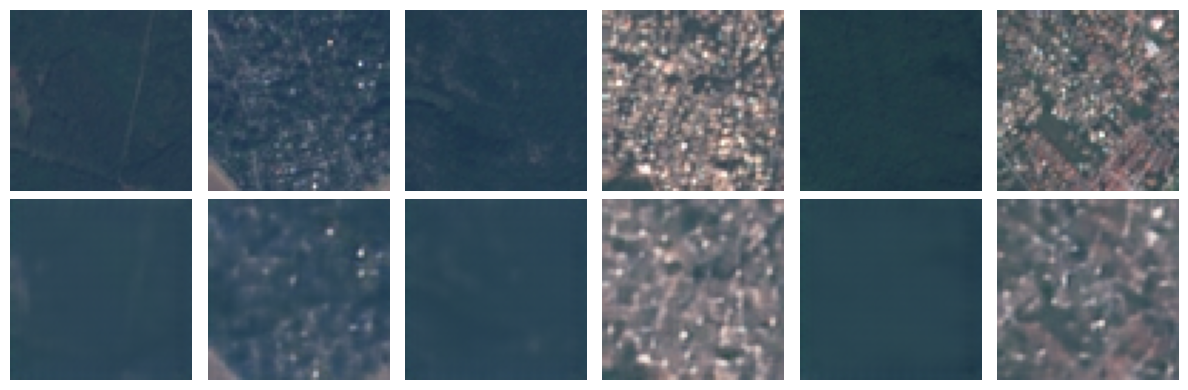


--- Reconstructions SoftShare ---


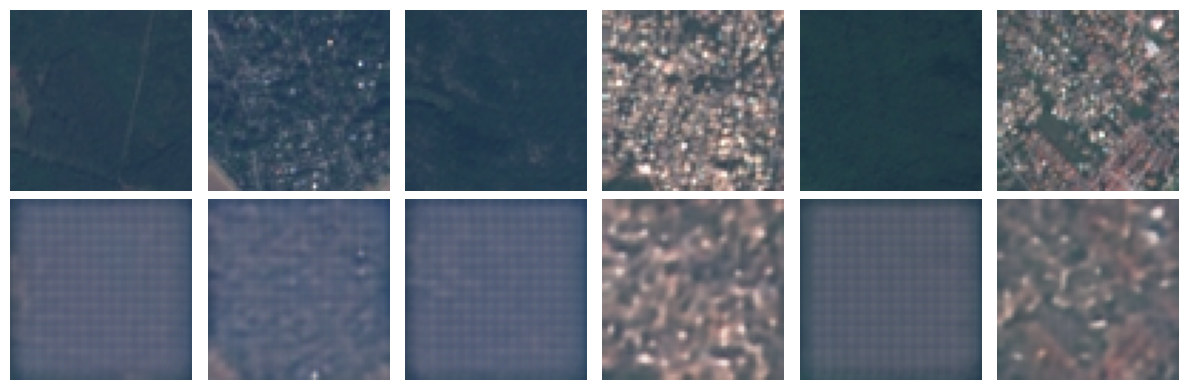

In [13]:
print("\n--- Reconstructions MTL ---")
show_reconstructions(model_mtl, val_loader, recon_mtl, device, n=6)

print("\n--- Reconstructions SoftShare ---")
show_reconstructions(model_soft, val_loader, recon_soft, device, n=6)

## Visualisations & diagnostics

Les cellules suivantes recomputent les métriques OOD pour les 3 modèles entraînés, sauvegardent un résumé JSON, tracent les courbes d'entraînement, les matrices de confusion, et sauvegardent des grilles de reconstructions et d'exemples par classe dans le dossier `results/`.

In [27]:
# Recompute OOD metrics for all models and save JSON
import os, json
import numpy as np
from pathlib import Path

Path('results').mkdir(exist_ok=True)

results = {}
models = [
    ('baseline', model, lambda m,x: m(x)),
    ('mtl', model_mtl, lambda m,x: m(x)[0]),
    ('softshare', model_soft, lambda m,x: m(x)[0])
]
for name, m, logits_fn in models:
    acc, cm = evaluate(m, ood_loader, logits_fn, device)
    results[name] = {
        'acc': float(acc),
        'cm': cm.cpu().numpy().tolist()
    }

with open('results/metrics_summary.json','w') as f:
    json.dump(results, f, indent=2)

print('Saved results/metrics_summary.json')
print(json.dumps(results, indent=2))

Saved results/metrics_summary.json
{
  "baseline": {
    "acc": 0.7333333333333333,
    "cm": [
      [
        29,
        31
      ],
      [
        1,
        59
      ]
    ]
  },
  "mtl": {
    "acc": 0.5833333333333334,
    "cm": [
      [
        11,
        49
      ],
      [
        1,
        59
      ]
    ]
  },
  "softshare": {
    "acc": 0.5083333333333333,
    "cm": [
      [
        1,
        59
      ],
      [
        0,
        60
      ]
    ]
  }
}


Saved results/training_curves.png


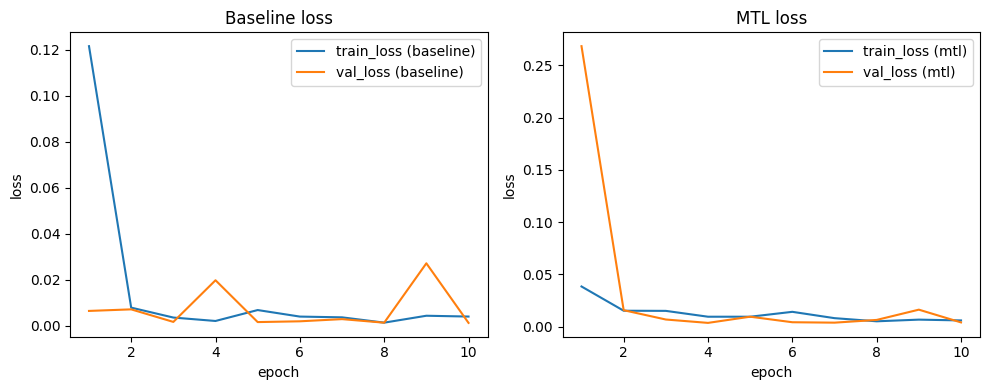

In [28]:
# Plot training curves (train loss, val loss, val acc) for baseline and MTL
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
# baseline
if 'hist' in globals():
    train_loss = [h[0] for h in hist]
    val_loss = [h[1] for h in hist]
    acc = [h[2] for h in hist]
    epochs = range(1, len(hist)+1)
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label='train_loss (baseline)')
    plt.plot(epochs, val_loss, label='val_loss (baseline)')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
    plt.title('Baseline loss')

# mtl
if 'hist_mtl' in globals():
    train_loss = [h[0] for h in hist_mtl]
    val_loss = [h[1] for h in hist_mtl]
    acc = [h[2] for h in hist_mtl]
    epochs = range(1, len(hist_mtl)+1)
    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, label='train_loss (mtl)')
    plt.plot(epochs, val_loss, label='val_loss (mtl)')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
    plt.title('MTL loss')

plt.tight_layout()
plt.savefig('results/training_curves.png', dpi=150)
print('Saved results/training_curves.png')
plt.show()

Installing seaborn...
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl (10.7 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl (10.7 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cac

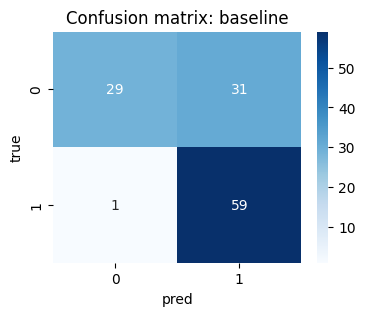

Saved results/cm_mtl.png


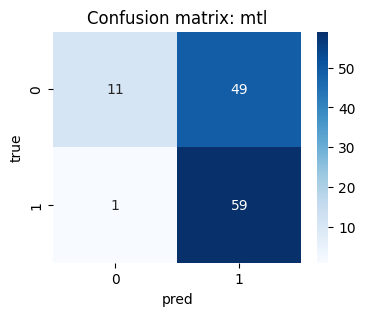

Saved results/cm_softshare.png


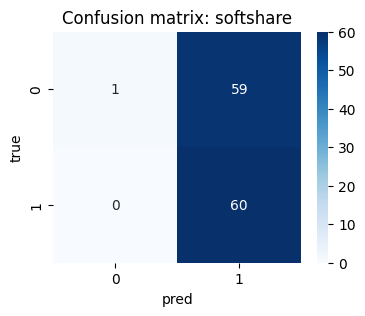

In [31]:
# Install seaborn if missing and plot confusion matrices for each model
# Using %pip so the install affects the notebook kernel environment
try:
    import seaborn as sns
except Exception:
    print('Installing seaborn...')
    get_ipython().run_line_magic('pip', 'install seaborn')
    import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

for name in ['baseline','mtl','softshare']:
    cm = np.array(results[name]['cm'])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('pred'); plt.ylabel('true')
    plt.title(f'Confusion matrix: {name}')
    out = f'results/cm_{name}.png'
    plt.savefig(out, dpi=150, bbox_inches='tight')
    print('Saved', out)
    plt.show()

In [ ]:
# Save reconstruction grids for MTL and SoftShare and baseline reconstructions if available
import torchvision

def save_recon_grid(model, recon_fn, loader, name, device, n=6, fname=None):
    imgs, _ = next(iter(loader))
    imgs = imgs[:n].to(device)
    with torch.no_grad():
        recon = recon_fn(model, imgs)
    imgs_cpu = imgs.cpu()  # (n, C, H, W)
    recon_cpu = recon.cpu()
    grid_in = torchvision.utils.make_grid((imgs_cpu*0.5+0.5), nrow=n)
    grid_rec = torchvision.utils.make_grid((recon_cpu*0.5+0.5), nrow=n)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.imshow(np.transpose(grid_in.numpy(), (1,2,0))); plt.axis('off'); plt.title(f'in-{name}')
    plt.subplot(1,2,2); plt.imshow(np.transpose(grid_rec.numpy(), (1,2,0))); plt.axis('off'); plt.title(f'recon-{name}')
    out_path = fname or f'results/recon_{name}.png'
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    print('Saved', out_path)
    plt.show()

# baseline model does not have explicit recon function, but we can skip baseline recon if not present
try:
    save_recon_grid(model_mtl, recon_mtl, val_loader, 'mtl', device, n=6)
except Exception as e:
    print('MTL recon save failed:', e)

try:
    save_recon_grid(model_soft, recon_soft, val_loader, 'softshare', device, n=6)
except Exception as e:
    print('SoftShare recon save failed:', e)


In [ ]:
# Class distribution and example montage per class
from collections import defaultdict

# Count per original 'base' ImageFolder classes in train dataset
counts = defaultdict(int)
examples = defaultdict(list)
for img, lbl in train_loader.dataset:
    counts[base.classes[lbl]] += 1
    if len(examples[base.classes[lbl]]) < 6:
        examples[base.classes[lbl]].append(img)

# Bar chart of class counts
plt.figure(figsize=(6,3))
plt.bar(list(counts.keys()), list(counts.values()))
plt.title('Train class counts')
plt.savefig('results/class_counts.png', dpi=150)
print('Saved results/class_counts.png')
plt.show()

# Montage: show up to 6 examples per class
for cls, imgs in examples.items():
    if len(imgs)==0:
        continue
    grid = torchvision.utils.make_grid([(t*0.5+0.5) for t in imgs], nrow=len(imgs))
    plt.figure(figsize=(8,2))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.axis('off')
    plt.title(f'Examples: {cls}')
    out = f'results/examples_{cls}.png'
    plt.savefig(out, dpi=150, bbox_inches='tight')
    print('Saved', out)
    plt.show()

In [32]:
# Export high-resolution assets for slides and write slide notes
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path
import torchvision

Path('results').mkdir(exist_ok=True)

# 1) High-res training curves (300 dpi) + PDF
plt.figure(figsize=(12,5))
if 'hist' in globals():
    epochs = range(1, len(hist)+1)
    train_loss = [h[0] for h in hist]
    val_loss = [h[1] for h in hist]
    plt.plot(epochs, train_loss, label='train_loss (baseline)')
    plt.plot(epochs, val_loss, label='val_loss (baseline)')
if 'hist_mtl' in globals():
    epochs_m = range(1, len(hist_mtl)+1)
    train_loss_m = [h[0] for h in hist_mtl]
    val_loss_m = [h[1] for h in hist_mtl]
    plt.plot(epochs_m, val_loss_m, '--', label='val_loss (mtl)')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Training / Validation loss (baseline + MTL)')
plt.tight_layout()
plt.savefig('results/training_curves_highres.png', dpi=300)
plt.savefig('results/training_curves_highres.pdf')
plt.close()
print('Saved training_curves_highres.png/pdf')

# 2) High-res confusion matrices (300 dpi + pdf)
try:
    import seaborn as sns
except Exception:
    get_ipython().run_line_magic('pip', 'install seaborn')
    import seaborn as sns

for name in ['baseline','mtl','softshare']:
    cm = np.array(results[name]['cm'])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('pred'); plt.ylabel('true')
    plt.title(f'Confusion matrix: {name}')
    out_png = f'results/cm_{name}_highres.png'
    out_pdf = f'results/cm_{name}_highres.pdf'
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.savefig(out_pdf, bbox_inches='tight')
    plt.close()
    print('Saved', out_png, 'and', out_pdf)

# 3) High-res reconstructions grids (if recon functions present)
def save_recon_highres(model, recon_fn, loader, name):
    try:
        imgs, _ = next(iter(loader))
        imgs = imgs[:6].to(device)
        with torch.no_grad():
            recon = recon_fn(model, imgs)
        imgs_cpu = imgs.cpu()
        recon_cpu = recon.cpu()
        grid_in = torchvision.utils.make_grid((imgs_cpu*0.5+0.5), nrow=6)
        grid_rec = torchvision.utils.make_grid((recon_cpu*0.5+0.5), nrow=6)
        fig, axs = plt.subplots(1,2, figsize=(12,4))
        axs[0].imshow(np.transpose(grid_in.numpy(), (1,2,0)))
        axs[0].axis('off'); axs[0].set_title('input')
        axs[1].imshow(np.transpose(grid_rec.numpy(), (1,2,0)))
        axs[1].axis('off'); axs[1].set_title('recon')
        out_png = f'results/recon_{name}_highres.png'
        out_pdf = f'results/recon_{name}_highres.pdf'
        plt.tight_layout()
        plt.savefig(out_png, dpi=300, bbox_inches='tight')
        plt.savefig(out_pdf, bbox_inches='tight')
        plt.close()
        print('Saved', out_png, 'and', out_pdf)
    except Exception as e:
        print('Skipping recon for', name, ':', e)

# Try for MTL and SoftShare
save_recon_highres(model_mtl, recon_mtl, val_loader, 'mtl')
save_recon_highres(model_soft, recon_soft, val_loader, 'softshare')

# 4) Slide notes: concise bullets + speaker notes
slide_notes = {
    'title': 'MTL vs Baseline — Key results',
    'summary': [
        'Dataset: Forest vs Residential (images 64x64)',
        'Training on Apple M4 (MPS); 10 epochs per model',
    ],
    'metrics': results,
    'takeaways': [
        'Baseline CNN: high val accuracy on validation set, OOD acc ~0.73, but struggles on Forest subset (confusion with Residential).',
        'MTL model: similar validation acc but lower OOD overall (0.58) — seems to underperform on Forest more than baseline.',
        'SoftShare: also shows high val acc but very low Forest OOD accuracy (near 0), indicating overfitting to Residential subdomains or dataset shift.',
        'Dense/Medium OOD subgroups achieve high accuracy across models — Forest appears to be the problematic domain.',
    ],
    'speaker_notes': [
        'Explain the difference between validation accuracy (in-domain) and OOD accuracy (external set).',
        'Point to confusion matrices: Forest (true class 0) is often predicted as Residential (1) — indicate domain gap and possible label/visual ambiguity.',
        'Hypotheses: class imbalance, covariate shift, or background features dominating; recommend visual inspection and balanced sampling.',
        'Next steps: collect more Forest examples, try domain adaptation / augmentation focused on Forest, or fine-tune with OOD samples.'
    ]
}

with open('results/slide_notes.md','w') as f:
    f.write('# MTL vs Baseline — Key results\n\n')
    for s in slide_notes['summary']:
        f.write(f'- {s}\n')
    f.write('\n## Metrics\n')
    json.dump(slide_notes['metrics'], f, indent=2)
    f.write('\n\n## Takeaways\n')
    for t in slide_notes['takeaways']:
        f.write(f'- {t}\n')
    f.write('\n## Speaker notes\n')
    for n in slide_notes['speaker_notes']:
        f.write(f'- {n}\n')

print('Saved results/slide_notes.md')

# 5) Create a ZIP with slide-ready highres assets
import subprocess
files_to_zip = [
    'results/training_curves_highres.png',
    'results/training_curves_highres.pdf',
    'results/cm_baseline_highres.png', 'results/cm_baseline_highres.pdf',
    'results/cm_mtl_highres.png', 'results/cm_mtl_highres.pdf',
    'results/cm_softshare_highres.png', 'results/cm_softshare_highres.pdf',
    'results/recon_mtl_highres.png', 'results/recon_mtl_highres.pdf',
    'results/recon_softshare_highres.png', 'results/recon_softshare_highres.pdf',
    'results/slide_notes.md'
]
# Filter files that exist
files_to_zip = [p for p in files_to_zip if Path(p).exists()]
zip_name = 'results_slide.zip'
if files_to_zip:
    cmd = ['zip', '-j', zip_name] + files_to_zip
    subprocess.run(cmd, check=False)
    print('Created', zip_name)
else:
    print('No files to zip; none of the expected high-res files were found')

Saved training_curves_highres.png/pdf
Saved results/cm_baseline_highres.png and results/cm_baseline_highres.pdf
Saved results/cm_mtl_highres.png and results/cm_mtl_highres.pdf
Saved results/cm_softshare_highres.png and results/cm_softshare_highres.pdf
Saved results/cm_mtl_highres.png and results/cm_mtl_highres.pdf
Saved results/cm_softshare_highres.png and results/cm_softshare_highres.pdf
Saved results/recon_mtl_highres.png and results/recon_mtl_highres.pdf
Saved results/recon_mtl_highres.png and results/recon_mtl_highres.pdf
Saved results/recon_softshare_highres.png and results/recon_softshare_highres.pdf
Saved results/slide_notes.md
  adding: training_curves_highres.png (deflated 15%)
  adding: training_curves_highres.pdf (deflated 33%)
  adding: cm_baseline_highres.png (deflated 14%)
  adding: cm_baseline_highres.pdf (deflated 30%)
  adding: cm_mtl_highres.png (deflated 15%)
  adding: cm_mtl_highres.pdf (deflated 30%)
  adding: cm_softshare_highres.png (deflated 15%)
  adding: cm_so

In [33]:
# Plot and save accuracy curves (val accuracy) for baseline and MTL (high-res)
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
Path('results').mkdir(exist_ok=True)

plt.figure(figsize=(8,4))
plotted = False
if 'hist' in globals():
    acc = [h[2] for h in hist]
    epochs = range(1, len(acc)+1)
    plt.plot(epochs, acc, marker='o', label='val_acc (baseline)')
    plotted = True
if 'hist_mtl' in globals():
    acc_m = [h[2] for h in hist_mtl]
    epochs_m = range(1, len(acc_m)+1)
    plt.plot(epochs_m, acc_m, marker='s', label='val_acc (mtl)')
    plotted = True

if not plotted:
    print('No history variables available to plot accuracy (no hist or hist_mtl).')
else:
    plt.xlabel('epoch')
    plt.ylabel('val accuracy')
    plt.ylim(0,1.02)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.title('Validation accuracy')
    out_png = 'results/accuracy_curves_highres.png'
    out_pdf = 'results/accuracy_curves_highres.pdf'
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.savefig(out_pdf)
    plt.close()
    print('Saved', out_png, 'and', out_pdf)


Saved results/accuracy_curves_highres.png and results/accuracy_curves_highres.pdf
